# Chord Cleaning

### Imports

In [2]:
import pandas as pd
import numpy as np
import random
import string
import re
import json
import ast
from collections import Counter
import statistics as stats
import matplotlib.pyplot as plt
import os

data_path = os.getenv('DATA_PATH')

### Getting workable DF

In [3]:
raw_df = pd.read_csv(data_path)
slim_raw_df = raw_df[['artist_name', 'song_name', 'chords', 'genres', 'popularity']]
slim_raw_df.head(3)

,artist_name,song_name,chords,genres,popularity
0,Justin Bieber,"10,000 Hours",{3: 'G G/B ...,"['canadian pop', 'pop', 'post-teen pop']",100
1,Justin Bieber,2 Much,"{1: 'Intro: F#m7 D2 ', 4: 'F#m7 ', 8: 'D2 ', ...","['canadian pop', 'pop', 'post-teen pop']",100
2,Justin Bieber,2u (feat. David Guetta),{1: 'Em D C C...,"['canadian pop', 'pop', 'post-teen pop']",100


In [4]:
# first_raw = ast.literal_eval(slim_raw_df.loc[0, 'chords'])
# first_raw

## Data Exploration

the song is 35 measures long.
the first 4 lines of chords are:
G-------------G/B-------------------------C-
(length: 44)
------------------G-
(length: 20)
G------------------G/B-------------------------C-
(length: 49)
----------------G-
(length: 18)


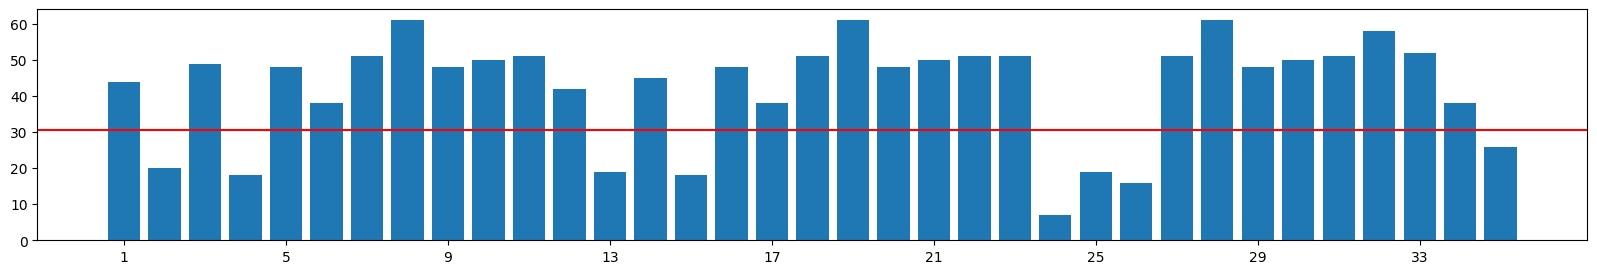

In [5]:
song_ch_lol = []
i = 0

song1 = slim_raw_df.chords[0]

song_mm_ch_dict = ast.literal_eval(song1)
song_ch_lol = [ch for ch in song_mm_ch_dict.values()]
max_line = len(song_ch_lol)

print(f'the song is {max_line} measures long.')
print('the first 4 lines of chords are:')
for ch in song_ch_lol:
    new = ch.replace(" ", "-")
    print(new)
    l = len(new)
    print(f'(length: {l})')
    i += 1
    if i == 4: break

# get line lengths
line_lens = [len(x) for x in song_ch_lol]
max_line_len = max(line_lens)

# {measure_no: chords_list}: dict
measures = [x for x in range(1, len(song_ch_lol)+1)]

fig1, ax1 = plt.subplots(figsize=(20,3))
ax1.axhline(max_line_len/2, color='red')
ax1.bar(measures, line_lens)
xt = np.arange(1, max_line+1, 4)
ax1.set(xticks=xt, xticklabels=xt)
plt.show()

#### See Chord Frequency

In [6]:
chords_ser_raw = slim_raw_df.chords.copy()

chords_ser_lists = pd.Series(index=range(len(slim_raw_df)), dtype='object')

for i, song in enumerate(chords_ser_raw):
    song_mm_ch_dict = ast.literal_eval(song)
    song_ch_lol = [ch for ch in song_mm_ch_dict.values()]
    chords_ser_lists.iloc[i] = song_ch_lol

chords_ser_lists.head()

0    [G             G/B                         C ,...
1    [Intro: F#m7  D2 , F#m7 , D2 , F#m7 ,         ...
2    [Em            D         C               C  D ...
3    [ Intro: Em  Bm  Am  C   (2x) ,           Em  ...
4    [Intro: Gm - Dm - C - C   x2 ,        Gm      ...
dtype: object

In [7]:
chords_counter = Counter()
for song in chords_ser_lists:
    for line in song:
        l = line.split(' ')
        chords_counter.update(l)
del chords_counter['']

chord_count_df = pd.Series(dict(chords_counter)).to_frame('chord_count')
sorted_cc_df = chord_count_df.sort_values(by='chord_count', ascending=False)
print('the total amount of unique "chords" is: ', len(sorted_cc_df))

the total amount of unique "chords" is:  103294


In [7]:
# pd.options.display.max_rows = 100
# sorted_cc_df.head(100)

In [8]:
letters = list(string.ascii_uppercase)[:7]
non_chord_filter = [chord for chord in sorted_cc_df.index if chord[0] in letters]
filtered_cc_df = sorted_cc_df[sorted_cc_df.index.isin(non_chord_filter)]
print('the total amount of unique "chords" is: ', len(filtered_cc_df))

the total amount of unique "chords" is:  77872


In [9]:
# pd.set_option('display.max_rows', 200)
# filtered_cc_df.iloc[0:200]

In [10]:
# slim_chord_counts_dict = {}
# for chord, count in chords_count_dict.items():
#     if count <= low_freq_to_remove:
#         pass
#     else:
#         slim_chord_counts_dict[chord] = count

## Cleaning

### Test

In [11]:
# # editing repeats
# test_chords = 'Intro: Gm - Dm - C - C   x2 Gm7   F % Csus4/D'
# chords_wo_reps = ''

# # find repeat symbols (%, - , x2, 2x) and replace with preceding chord
# if re.findall(r'%|2x|x2|\s-\s', test_chords):
#     reps = re.findall(r'(\S+)(?=\s*(%|2x|x2|\s-\s))|([A-Z]\S+)', test_chords)
#     for x in reps:
#         if x[0] != '':
#             chords_wo_reps += x[0] + ' ' + x[0] + ' '
#         else:
#             chords_wo_reps += x[2] + ' '
# else:
#     chords_wo_reps = test_chords
# print(test_chords)
# print(chords_wo_reps)

Intro: Gm - Dm - C - C   x2 Gm7   F % Csus4/D
Intro: Gm Gm Dm Dm C C C C Gm7 F F Csus4/D 


In [12]:
# # cleaning up chords
# test2_chords = '      Intro: G-F-G  FMm7,    G\\F\\F\\F,       Amsus6 GM7/D#   (F3)    BbFbCG     '

# # remove non-useful punctuation
# no_punc_ch = re.sub(r'-+|[()|,.]|\\', ' ', test2_chords)

# # remove spaces
# mult_sp_rem_ch = re.sub(r'\s+', ' ', no_punc_ch)
# beg_sp_rem_ch = re.sub(r'^\s+', '', mult_sp_rem_ch)
# end_sp_rem_ch = re.sub(r'\s+$', '', beg_sp_rem_ch)
    
# end_sp_rem_ch

'Intro: G F G FMm7 G F F F Amsus6 GM7/D# F3 BbFbCG'

### Clean DF

In [9]:
raw_chords_ser = chords_ser_lists.copy()
cleaned_chords_ser = pd.Series(index=range(len(raw_chords_ser)), dtype='object')

In [10]:
# r'(?<!\s)/(?=[0-9])'

In [11]:
# bar charts
re1 = r'\S*[|]\S+[|]'
# repeat symbols 
re2 = r'%|2x|x[0-9]|x\s+[0-9]|\s-\s|\s/\s'
# non-useful punctuation
re3 = r'[|,.*?]|\\|~'
# more than 3 numbers in a row
re4 = r'[0-9]{4,}'
# words starting with letters after G
re5 = r'\s+[H-Zh-z]\w*' 
# special words
words = ['intro', 'interlude', 'bridge', 'INTRODUÇÃO', 'instrumental', 
         'solo', 'chorus', 'riff', 'break', 'guitar', 'verse', 'dução', 
         'final', 'once', '-once', 'hammer', 'outro', '-stop']
re6 = r"|".join(words)

full_re = re.compile("|".join([re1, re2, re3, re4, re5, re6]), re.IGNORECASE)
full_re

re.compile(r'\S*[|]\S+[|]|%|2x|x[0-9]|x\s+[0-9]|\s-\s|\s/\s|[|,.*?]|\\|~|[0-9]{4,}|\s+[H-Zh-z]\w*|intro|interlude|bridge|INTRODUÇÃO|instrumental|solo|chorus|riff|break|guitar|verse|dução|final|once|-once|hammer|outro|-stop',
           re.IGNORECASE|re.UNICODE)

In [12]:
for i, song in enumerate(raw_chords_ser):
    
    cleaned_song = ''
    j = 0
    for line in song:

        # remove unhelpful symbols (as shown above)
        subs = re.sub(full_re, ' ', line, )
        
        # remove parentheses, brackets, and colons
        cleaned_string = re.sub(r'[(){}:]', '', subs)

        # remove multiple spaces
        mult_sp_rem_ch = re.sub(r'\s+', ' ', cleaned_string)
        
        # remove front and trailing white spaces
        beg_end_sp_rem_song = re.sub(r'^\s+|\s+$', '', mult_sp_rem_ch)

        if j < len(song)-1:
            cleaned_song += beg_end_sp_rem_song + ' '
            j += 1
        else:
            cleaned_song += beg_end_sp_rem_song
            
    cleaned_chords_ser.iloc[i] = cleaned_song
    
cleaned_chords_ser.head()

0    G G/B C G G G/B C G G Em C G G Em C G G Em C G...
1    F#m7 D2 F#m7 D2 F#m7 D2 E F#m7 A/C# E D2 E F#m...
2    Em D C C D Em Em D C C D Em Em D C Am D Em G C...
3    Em Bm Am C Em Bm Am C Em Bm Am C Bm Em Bm Am C...
4    Gm Dm C C Gm Dm C C Gm Dm C C Gm A# C Gm A# C ...
dtype: object

In [13]:
cleaned_chords_counter = Counter()
for song in cleaned_chords_ser:
    try:
        l = song.split(' ')
    except:
        print(song)
        break
    cleaned_chords_counter.update(l)
del cleaned_chords_counter['']

cleaned_chord_count_df = pd.Series(dict(cleaned_chords_counter)).to_frame('chord_count')
cleaned_cc_df = cleaned_chord_count_df.sort_values(by='chord_count', ascending=False).reset_index(names=['chord'])
print('the total amount of unique "chords" is: ', len(cleaned_cc_df))
# cleaned_cc_df.head(100)

the total amount of unique "chords" is:  28766


In [14]:
pd.set_option('display.max_rows', 50)
cleaned_cc_df[:50]

,chord,chord_count
0,G,1057874
1,C,869870
2,D,817271
3,A,650900
4,F,523164
5,E,461956
6,Am,447426
7,Em,401865
8,Bm,249208
9,B,224850


In [16]:
# for idx, c in enumerate(cleaned_chords_ser):
#     if ' x ' in c:
#         print(idx, c)

In [17]:
# for m in raw_chords_ser[101]:
#     print(m)

In [15]:
# letters = list(string.ascii_uppercase)[:7]
# non_chord_filter = [chord for chord in sorted_cc_df.index if chord[0] in letters]
# cc_df = sorted_cc_df[sorted_cc_df.index.isin(non_chord_filter)]
# cc_df.iloc[100:200]

## Creating List of Correctly Formatted Chords

In [18]:
major_chords = ['C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'F', 'F#', 'Gb', 'G', 'G#', 'Ab', 'A', 'A#', 'Bb', 'B']

In [19]:
chords_df = pd.DataFrame(index=['', 'm', 'dim', 'aug', '5', 'aug5', '5b7',
                                'dim7', 'hdim7', 'm7', 'm-M7', '7', 'aug7', 'M7',  
                                'm9', '9', '7b9',  'M9', 'm11', '11',
                                'add2', 'add4', 'add6', 'add9', 
                                'madd2', 'madd4', 'madd6', 'madd9', 
                                '7add4', '7addb6', '7add6', 
                                'msus2', 'msus4', '7sus2', '7sus4', 'sus2', 'sus4'
                                ],
                         columns=major_chords)


In [20]:
for idx in chords_df.index:
    new_chords = [m + idx for m in major_chords]
    chords_df.loc[idx, :] = new_chords
chords_df.rename(index={'': 'major'}, inplace=True)
chords_df.head(3)

,C,C#,Db,D,D#,Eb,E,F,F#,Gb,G,G#,Ab,A,A#,Bb,B
major,C,C#,Db,D,D#,Eb,E,F,F#,Gb,G,G#,Ab,A,A#,Bb,B
m,Cm,C#m,Dbm,Dm,D#m,Ebm,Em,Fm,F#m,Gbm,Gm,G#m,Abm,Am,A#m,Bbm,Bm
dim,Cdim,C#dim,Dbdim,Ddim,D#dim,Ebdim,Edim,Fdim,F#dim,Gbdim,Gdim,G#dim,Abdim,Adim,A#dim,Bbdim,Bdim


In [66]:
sharp_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 
                'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
flats_notes = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B', 
                'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
sharp_keys = ['D', 'E', 'G', 'A', 'B', 'Dm', 'Em', 'Fm', 'Bm']
flats_keys = ['C', 'F', 'Cm', 'Gm', 'Am']

slash_indexes = ['dim/b7', 'm/2', 'm/b3', 'm/3', 'm/4', 'm/5', 'm/6','m/b7', 'm/7',
                'm7/b3', 'm7/4', 'm7/b5', 'm7/5', 'm7/b7', 'm7/7', 
                '/2', '/b3', '/3', '/4', '/5', '/6','/b7', '/7', 
                '7/b2', '7/2', '7/b3', '7/3', '7/4', '7/5', '7/b6', '7/6','7/7', 
                '9/b3', '9/3', '9/4', '9/5', '9/6', '9/7',
                'M7/2', 'M7/b3', 'M7/3', 'M7/4', 'M7/5', 'M7/6','M7/b7']

whole_to_half = {'b2': 1, '2': 2, 'b3': 3, '3': 4, '4': 5, 'b5': 6,
                 '5': 7, 'b6': 8,'6': 9, 'b7': 10, '7': 11}

In [67]:
# big function
def get_slash_notes(slash_indexes, columns):
    slash_chord = pd.DataFrame(index=slash_indexes, columns=columns)
    i = 0 
    
    def find_slash(chord, notes, i):
        for si in slash_indexes:
            s = si.split('/')
            h = whole_to_half[s[1]]
            sc = f'{chord}{s[0]}/{notes[i+h]}'
            slash_chord.loc[si, chord] = sc
    
    def sort_f_s(chord, notes):
        for n in notes:
            if len(chord) > 1:
                i = notes.index(chord)
                find_slash(chord, notes, i)
            else:
                i = notes.index(chord[0])
                find_slash(chord, notes, i)
    
    for chord in columns:
        if chord in sharp_keys or '#' in chord:
            sort_f_s(chord, sharp_notes)
        else:
            sort_f_s(chord, flats_notes)
                
            
    return slash_chord

In [100]:
slash_chords_df = pd.concat([chords_df, get_slash_notes(slash_indexes, chords_df.columns)])
print(slash_chords_df.index)
slash_chords_df.head()

Index(['major', 'm', 'dim', 'aug', '5', 'aug5', '5b7', 'dim7', 'hdim7', 'm7',
       'm-M7', '7', 'aug7', 'M7', 'm9', '9', '7b9', 'M9', 'm11', '11', 'add2',
       'add4', 'add6', 'add9', 'madd2', 'madd4', 'madd6', 'madd9', '7add4',
       '7addb6', '7add6', 'msus2', 'msus4', '7sus2', '7sus4', 'sus2', 'sus4',
       'dim/b7', 'm/2', 'm/b3', 'm/3', 'm/4', 'm/5', 'm/6', 'm/b7', 'm/7',
       'm7/b3', 'm7/4', 'm7/b5', 'm7/5', 'm7/b7', 'm7/7', '/2', '/b3', '/3',
       '/4', '/5', '/6', '/b7', '/7', '7/b2', '7/2', '7/b3', '7/3', '7/4',
       '7/5', '7/b6', '7/6', '7/7', '9/b3', '9/3', '9/4', '9/5', '9/6', '9/7',
       'M7/2', 'M7/b3', 'M7/3', 'M7/4', 'M7/5', 'M7/6', 'M7/b7'],
      dtype='object')


,C,C#,Db,D,D#,Eb,E,F,F#,Gb,G,G#,Ab,A,A#,Bb,B
major,C,C#,Db,D,D#,Eb,E,F,F#,Gb,G,G#,Ab,A,A#,Bb,B
m,Cm,C#m,Dbm,Dm,D#m,Ebm,Em,Fm,F#m,Gbm,Gm,G#m,Abm,Am,A#m,Bbm,Bm
dim,Cdim,C#dim,Dbdim,Ddim,D#dim,Ebdim,Edim,Fdim,F#dim,Gbdim,Gdim,G#dim,Abdim,Adim,A#dim,Bbdim,Bdim
aug,Caug,C#aug,Dbaug,Daug,D#aug,Ebaug,Eaug,Faug,F#aug,Gbaug,Gaug,G#aug,Abaug,Aaug,A#aug,Bbaug,Baug
5,C5,C#5,Db5,D5,D#5,Eb5,E5,F5,F#5,Gb5,G5,G#5,Ab5,A5,A#5,Bb5,B5


## Shove chords into correct format

In [73]:
yes_chords = list(slash_chords_df.values[0])
for x in slash_chords_df.values[1:]:
    chords = list(x)
    for c in chords:
        yes_chords.append(c)

In [101]:
substitutions = {'maj': '', ',': '', 'º': 'dim', '*': 'dim', '5+': 'aug', '7M': 'M7', '°': 'dim',
                 'maj7': 'M7', 'm7b5': 'hdim7', 'm7+': 'm-M7', '7+': 'aug7', 'm75-': 'hdim7',
                 '79': '9', 'm5-/7': 'dim/b7', '711': '7add4', '7b13': '7addb6', 
                 '713': '7add6', '4/7/9': '9add4', '69': '9add6', '/9-': '/b2', '59': '9',
                 '/9': '/2', '/5-': '/b5', '/13-': '/b6', '/5+': '/b6', '/13': '/6', '13': 'add6',
                 '2': 'add2', '4': 'add4', '6': 'add6', 'sus': 'sus4'
                 }

In [102]:
enharmonics = ['Gm/Bb', 'F#/Bb', 'B/Eb', 'Am/F', 'G/Bb', 'F#/D', 'B/C', 'E/Ab', 'B/G']

In [107]:
def merge_chords(chords_column):
    chords_column_copy = chords_column.copy()
    merged_chords = []
    rejected = []
    
    # if keys in subs in chord, replace with values
    def check_subs(chord):
        for k, s in substitutions.items():
            if k in chord: 
                ch_sub = chord.replace(k, s)
                return ch_sub
        if chord in yes_chords:
            return chord
        elif chord in enharmonics:
            return chord
        else:
            rejected.append(chord)
            return ''
    
    for song in chords_column_copy:
        song_l = song.split()
        for idx, ch in enumerate(song_l):
            # if idx == 0 and m == ?:
            chs = check_subs(ch)
            song_l[idx] = chs                
        merged_chords.append(song_l)
    
    rejects_c = Counter(rejected)
    
    rejects_df = pd.Series(dict(rejects_c)).to_frame('rejects').sort_values(by='rejects', ascending=False)
 
    return merged_chords, rejects_df

In [108]:
merged, rejects = merge_chords(cleaned_chords_ser)
merged

[['G',
  'G/B',
  'C',
  'G',
  'G',
  'G/B',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'G/B',
  'C',
  'G',
  'G',
  'G/B',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'Bm',
  'C',
  'Bm',
  'C',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'G',
  'G',
  'Em',
  'C',
  'C',
  'G',
  'G',
  'G',
  'Em',
  'C',
  'G'],
 ['F#m7',
  'Dadd2',
  'F#m7',
  'Dadd2',
  'F#m7',
  'Dadd2',
  'E',
  'F#m7',
  'A/C#',
  'E',
  'Dadd2',
  'E',
  'F#m7',
  'Bm',
  'A/C#',
  'Dadd2',
  'E',
  'F#m7

In [106]:
# rejects[0:50]

In [95]:
# slash_chords_df['F#']

In [ ]:
cleaned_chords_counter = Counter()
for song in cleaned_chords_ser:
    try:
        l = song.split(' ')
    except:
        print(song)
        break
    cleaned_chords_counter.update(l)
del cleaned_chords_counter['']

cleaned_chord_count_df = pd.Series(dict(cleaned_chords_counter)).to_frame('chord_count')
cleaned_cc_df = cleaned_chord_count_df.sort_values(by='chord_count', ascending=False).reset_index(names=['chord'])
print('the total amount of unique "chords" is: ', len(cleaned_cc_df))
# cleaned_cc_df.head(100)

## Unused Code

In [ ]:
# rejects_counter = Counter()
# for r in rejects:
#     for value in song.values():
#         l = value.split(' ')
#         chords_counter.update(l)

# rejects_df = pd.Series(dict(rejects_counter)).to_frame('rejects')
# sorted_rej_df = rejects_df.sort_values(by='rejects', ascending=False)
# sorted_rej_df

In [ ]:
# # big function
# def translate_slashes(slash_indexes, columns):
#     slash_chord = pd.DataFrame(index=slash_indexes, columns=columns)
#     i = 0 
    
#     def find_slash(chord, notes, i):
#         for si in slash_indexes:
#             s = si.split('/')
#             h = whole_to_half[s[1]]
#             sc = f'{chord}{s[0]}/{notes[i+h]}'
#             slash_chord.loc[si, chord] = sc
    
#     def sort_f_s(chord, notes):
#         for n in notes:
#             if n in chord :
#                 i = notes.index(chord[0])
#                 find_slash(chord, notes, i)
#             elif len(chord) > 1:
#                 if '#' == chord[1]:
#                     i = sharp_notes.index(chord[:2])
#                     find_slash(chord, sharp_notes, i)
#                 elif 'b' == chord[1]:
#                     i = flats_notes.index(chord[:2])
#                     find_slash(chord, flats_notes, i)
    
#     for chord in columns:
#         sort_f_s(chord, sharp_notes)
#         sort_f_s(chord, flats_notes)
                
            
#     return slash_chord

In [ ]:
# slash_chords_df = pd.concat([chords_df, get_slash_notes(slash_indexes, chords_df.columns)])
